## Exp-013 (ULMS BERT)

Exp-002からの変更点
- title_abstのhead+tailで実装（head 128 / last 382)
- max_len = 512に設定


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Sep  3 04:17:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers pycld2

     |████████████████████████████████| 2.8 MB 16.7 MB/s 
     |████████████████████████████████| 41.4 MB 66 kB/s 
     |████████████████████████████████| 3.3 MB 72.4 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
     |████████████████████████████████| 636 kB 62.4 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834322 sha256=c9cecf3711e1b0dbe9d9f0ba4f9744c87809acbfa6c5a0c2ec2c2e97d5260e69
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [ ]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import spacy
from nltk.corpus import stopwords
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
class CFG:
  exp = "exp13h"
  seed = 71
  fold = 5
  max_len = 150
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [ ]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [ ]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [ ]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [ ]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [ ]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    # config を設定することで、元の設定を変更できる？
    # https://www.kaggle.com/c/commonlitreadabilityprize/discussion/260729
    # 最終的にsigmoidに通すから、num_labelsは1でいい
    self.bert = BertForSequenceClassification.from_pretrained(CONFIG.model_name, num_labels=1)
    # この辺を調整することで、モデル内の最終層に追加することができる。
    # bertのoutputがclassificationなんで、そこを変更しないと
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    bert_output = self.sigmoid(bert_output.logits).squeeze()

    return bert_output

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [ ]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [ ]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer = AdamW(model.parameters(), lr=CONFIG.lr)

  # Loss_function
  loss_function = nn.BCELoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [ ]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [ ]:
def remove_non_alphabetic(texts):
    text_list=[]

    for text in texts: 
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.replace("  ", " ")
        text_list.append(text)
    return text_list


nltk.download('stopwords')
stop_words = stopwords.words('english')

def clean_stopword(text_list):
    texts_temp= [[word for word in text.lower().split() if word not in stop_words] for text in text_list]
    return texts_temp


def split_copyright(texts):

    text_list=[]

    for text in texts:    

        if "Copyright" in text:
            text = text.split('Copyright')[0]
            text_list.append(text)
        else:
            text_list.append(text)
    return text_list

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts_list, allowed_postags=['PROPN','VERB','NOUN','ADJ', 'ADV']):
   
    texts_pre=[]

    for sent in texts_list:
        doc = nlp(" ".join(sent)) 
        texts_pre.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_pre

def preprocess_text(text):
    text = remove_non_alphabetic(text)
    text = split_copyright(text)
    text = clean_stopword(text)
    #text = lemmatization(text)
    
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [ ]:
train = get_train_data(train)
train.head()

,id,title,abstract,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,1
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,0


In [ ]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,fold,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,1,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,0,Prolonged shedding of SARS-CoV-2 in an elderly...


In [ ]:
title_abst_train= train.title_abst
title_abst_test = test.title_abst

title_abst_train= preprocess_text(title_abst_train)
title_abst_test = preprocess_text(title_abst_test)

# preprocess
train["title_abst"] = title_abst_train
test["title_abst"] = title_abst_test

In [ ]:
print(len(pd.read_csv(input_dir + "train.csv")))# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

print(len(train))

27145
26921


In [ ]:
train= train.reset_index(drop=True)

In [ ]:
train.head()

,id,title,abstract,judgement,fold,title_abst,title_word_len,title_lang
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,"[one, year, age, changes, mri, brain, volumes,...",10,en
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,1,"[supportive, csf, biomarker, evidence, enhance...",23,en
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,"[occurrence, basal, ganglia, germ, cell, tumor...",10,en
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,"[new, developments, diagnosis, therapy, crohn,...",13,en
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,0,"[prolonged, shedding, sars, cov, elderly, live...",16,en


In [ ]:
lengths=[]

for value in train.title_abst:
    length=len(value)
    lengths.append(length)

train["title_abst_len"] = lengths

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


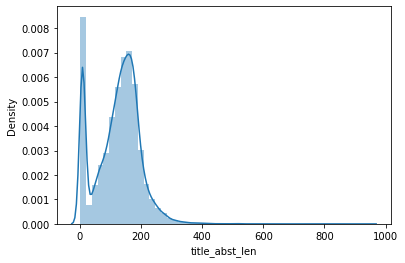

In [ ]:
import seaborn as sns
sns.distplot(train["title_abst_len"])

In [ ]:
contents_train=[]
contents_test=[]

for i in range(len(train)):
    length = len(train.title_abst[i])

    if length > 150:
        head = train.title_abst[i][:50]
        tail = list(collections.deque(train.title_abst[i],100))
        head.extend(tail)
        contents_train.append(head)

    else:
        contents_train.append(train.title_abst[i])

for i in range(len(test)):
    length = len(test.title_abst[i])

    if length > 150:
        head = test.title_abst[i][:50]
        tail = list(collections.deque(test.title_abst[i],100))
        head.extend(tail)
        contents_test.append(head)

    else:
        contents_test.append(test.title_abst[i])

In [ ]:
train["title_abst"] = contents_train
test["title_abst"] = contents_test

In [ ]:
lengths_train=[]
lengths_test=[]

for value in train.title_abst:
    length=len(value)
    lengths_train.append(length)

for value in test.title_abst:
    length=len(value)
    lengths_test.append(length)

train["title_abst_len"] = lengths_train
test["title_abst_len"] = lengths_test

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


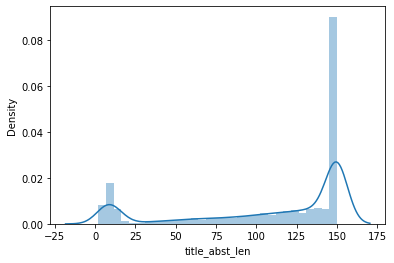

In [ ]:
import seaborn as sns
sns.distplot(train["title_abst_len"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


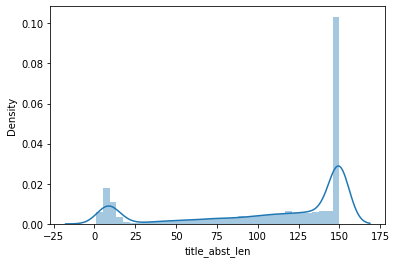

In [ ]:
import seaborn as sns
sns.distplot(test["title_abst_len"])

In [ ]:
#BERTに入力する用にスペース区切りに戻す
def reverse(x):
    x = " ". join([str(i) for i in list(x)])
    return x

train["title_abst"] = train["title_abst"].apply(lambda x : reverse(x))
test["title_abst"] = test["title_abst"].apply(lambda x : reverse(x))

In [ ]:
# Training
#border = len(train[train["judgement"] == 1]) / len(train["judgement"]) # 0.023245467689912133
#border = border * 0.6

mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df.csv", index=False)

========== fold: 0 training ==========
========== fold: 0 training ==========


Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/1345] Elapsed 0m 1s (remain 23m 46s) Loss: 0.7383 
Epoch: [1][100/1345] Elapsed 0m 14s (remain 2m 58s) Loss: 0.1254 
Epoch: [1][200/1345] Elapsed 0m 27s (remain 2m 39s) Loss: 0.0991 
Epoch: [1][300/1345] Elapsed 0m 41s (remain 2m 23s) Loss: 0.0853 
Epoch: [1][400/1345] Elapsed 0m 55s (remain 2m 9s) Loss: 0.0788 
Epoch: [1][500/1345] Elapsed 1m 8s (remain 1m 55s) Loss: 0.0786 
Epoch: [1][600/1345] Elapsed 1m 22s (remain 1m 41s) Loss: 0.0748 
Epoch: [1][700/1345] Elapsed 1m 35s (remain 1m 27s) Loss: 0.0704 
Epoch: [1][800/1345] Elapsed 1m 49s (remain 1m 14s) Loss: 0.0683 
Epoch: [1][900/1345] Elapsed 2m 2s (remain 1m 0s) Loss: 0.0642 
Epoch: [1][1000/1345] Elapsed 2m 16s (remain 0m 46s) Loss: 0.0642 
Epoch: [1][1100/1345] Elapsed 2m 29s (remain 0m 33s) Loss: 0.0637 
Epoch: [1][1200/1345] Elapsed 2m 43s (remain 0m 19s) Loss: 0.0637 
Epoch: [1][1300/1345] Elapsed 2m 56s (remain 0m 5s) Loss: 0.0626 
Epoch: [1][1344/1345] Elapsed 3m 2s (remain 0m 0s) Loss: 0.0622 
EVAL: [0/169]E

Epoch 1 - avg_train_loss: 0.0622  avg_val_loss: 0.0451  time: 197s
Epoch 1 - avg_train_loss: 0.0622  avg_val_loss: 0.0451  time: 197s
Epoch 1 - Score: 0.8950060168471721
Epoch 1 - Score: 0.8950060168471721
Epoch 1 - Save Best Score: 0.8950 
Epoch 1 - Save Best Score: 0.8950 
========== fold: 0 result ==========
========== fold: 0 result ==========
Best_Border: 0.02050516
Best_Border: 0.02050516
========== fold: 1 training ==========
========== fold: 1 training ==========


Best_Threshold：0.020505160568420954


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/1346] Elapsed 0m 0s (remain 9m 19s) Loss: 0.7186 
Epoch: [1][100/1346] Elapsed 0m 13s (remain 2m 51s) Loss: 0.1119 
Epoch: [1][200/1346] Elapsed 0m 27s (remain 2m 35s) Loss: 0.0992 
Epoch: [1][300/1346] Elapsed 0m 40s (remain 2m 21s) Loss: 0.0955 
Epoch: [1][400/1346] Elapsed 0m 54s (remain 2m 8s) Loss: 0.0875 
Epoch: [1][500/1346] Elapsed 1m 7s (remain 1m 54s) Loss: 0.0820 
Epoch: [1][600/1346] Elapsed 1m 21s (remain 1m 41s) Loss: 0.0780 
Epoch: [1][700/1346] Elapsed 1m 35s (remain 1m 27s) Loss: 0.0772 
Epoch: [1][800/1346] Elapsed 1m 48s (remain 1m 13s) Loss: 0.0729 
Epoch: [1][900/1346] Elapsed 2m 2s (remain 1m 0s) Loss: 0.0711 
Epoch: [1][1000/1346] Elapsed 2m 15s (remain 0m 46s) Loss: 0.0712 
Epoch: [1][1100/1346] Elapsed 2m 29s (remain 0m 33s) Loss: 0.0694 
Epoch: [1][1200/1346] Elapsed 2m 42s (remain 0m 19s) Loss: 0.0670 
Epoch: [1][1300/1346] Elapsed 2m 56s (remain 0m 6s) Loss: 0.0653 
Epoch: [1][1345/1346] Elapsed 3m 2s (remain 0m 0s) Loss: 0.0643 
EVAL: [0/169]El

Epoch 1 - avg_train_loss: 0.0643  avg_val_loss: 0.0343  time: 197s
Epoch 1 - avg_train_loss: 0.0643  avg_val_loss: 0.0343  time: 197s
Epoch 1 - Score: 0.9365325077399382
Epoch 1 - Score: 0.9365325077399382
Epoch 1 - Save Best Score: 0.9365 
Epoch 1 - Save Best Score: 0.9365 
========== fold: 1 result ==========
========== fold: 1 result ==========
Best_Border: 0.06396212
Best_Border: 0.06396212
========== fold: 2 training ==========
========== fold: 2 training ==========


Best_Threshold：0.06396211818161364


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/1345] Elapsed 0m 0s (remain 9m 6s) Loss: 0.7751 
Epoch: [1][100/1345] Elapsed 0m 13s (remain 2m 51s) Loss: 0.1312 
Epoch: [1][200/1345] Elapsed 0m 27s (remain 2m 36s) Loss: 0.1149 
Epoch: [1][300/1345] Elapsed 0m 41s (remain 2m 22s) Loss: 0.0976 
Epoch: [1][400/1345] Elapsed 0m 54s (remain 2m 8s) Loss: 0.0881 
Epoch: [1][500/1345] Elapsed 1m 8s (remain 1m 54s) Loss: 0.0803 
Epoch: [1][600/1345] Elapsed 1m 21s (remain 1m 41s) Loss: 0.0768 
Epoch: [1][700/1345] Elapsed 1m 35s (remain 1m 27s) Loss: 0.0739 
Epoch: [1][800/1345] Elapsed 1m 48s (remain 1m 14s) Loss: 0.0705 
Epoch: [1][900/1345] Elapsed 2m 2s (remain 1m 0s) Loss: 0.0669 
Epoch: [1][1000/1345] Elapsed 2m 16s (remain 0m 46s) Loss: 0.0649 
Epoch: [1][1100/1345] Elapsed 2m 29s (remain 0m 33s) Loss: 0.0630 
Epoch: [1][1200/1345] Elapsed 2m 43s (remain 0m 19s) Loss: 0.0612 
Epoch: [1][1300/1345] Elapsed 2m 56s (remain 0m 5s) Loss: 0.0601 
Epoch: [1][1344/1345] Elapsed 3m 2s (remain 0m 0s) Loss: 0.0594 
EVAL: [0/169]Ela

Epoch 1 - avg_train_loss: 0.0594  avg_val_loss: 0.0458  time: 197s
Epoch 1 - avg_train_loss: 0.0594  avg_val_loss: 0.0458  time: 197s
Epoch 1 - Score: 0.8938120702826585
Epoch 1 - Score: 0.8938120702826585
Epoch 1 - Save Best Score: 0.8938 
Epoch 1 - Save Best Score: 0.8938 
========== fold: 2 result ==========
========== fold: 2 result ==========
Best_Border: 0.02365287
Best_Border: 0.02365287
========== fold: 3 training ==========
========== fold: 3 training ==========


Best_Threshold：0.02365287060364412


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/1345] Elapsed 0m 0s (remain 9m 14s) Loss: 0.5627 
Epoch: [1][100/1345] Elapsed 0m 13s (remain 2m 51s) Loss: 0.1407 
Epoch: [1][200/1345] Elapsed 0m 27s (remain 2m 36s) Loss: 0.1087 
Epoch: [1][300/1345] Elapsed 0m 41s (remain 2m 22s) Loss: 0.0939 
Epoch: [1][400/1345] Elapsed 0m 54s (remain 2m 8s) Loss: 0.0843 
Epoch: [1][500/1345] Elapsed 1m 8s (remain 1m 54s) Loss: 0.0775 
Epoch: [1][600/1345] Elapsed 1m 21s (remain 1m 41s) Loss: 0.0730 
Epoch: [1][700/1345] Elapsed 1m 35s (remain 1m 27s) Loss: 0.0694 
Epoch: [1][800/1345] Elapsed 1m 48s (remain 1m 13s) Loss: 0.0683 
Epoch: [1][900/1345] Elapsed 2m 2s (remain 1m 0s) Loss: 0.0657 
Epoch: [1][1000/1345] Elapsed 2m 16s (remain 0m 46s) Loss: 0.0642 
Epoch: [1][1100/1345] Elapsed 2m 29s (remain 0m 33s) Loss: 0.0633 
Epoch: [1][1200/1345] Elapsed 2m 43s (remain 0m 19s) Loss: 0.0621 
Epoch: [1][1300/1345] Elapsed 2m 56s (remain 0m 5s) Loss: 0.0601 
Epoch: [1][1344/1345] Elapsed 3m 2s (remain 0m 0s) Loss: 0.0602 
EVAL: [0/169]El

Epoch 1 - avg_train_loss: 0.0602  avg_val_loss: 0.0459  time: 197s
Epoch 1 - avg_train_loss: 0.0602  avg_val_loss: 0.0459  time: 197s
Epoch 1 - Score: 0.9038800705467372
Epoch 1 - Score: 0.9038800705467372
Epoch 1 - Save Best Score: 0.9039 
Epoch 1 - Save Best Score: 0.9039 
========== fold: 3 result ==========
========== fold: 3 result ==========
Best_Border: 0.00735970
Best_Border: 0.00735970
========== fold: 4 training ==========
========== fold: 4 training ==========


Best_Threshold：0.007359701936017664


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/1346] Elapsed 0m 0s (remain 9m 18s) Loss: 0.7104 
Epoch: [1][100/1346] Elapsed 0m 13s (remain 2m 51s) Loss: 0.1249 
Epoch: [1][200/1346] Elapsed 0m 27s (remain 2m 36s) Loss: 0.1125 
Epoch: [1][300/1346] Elapsed 0m 41s (remain 2m 22s) Loss: 0.1069 
Epoch: [1][400/1346] Elapsed 0m 54s (remain 2m 8s) Loss: 0.0981 
Epoch: [1][500/1346] Elapsed 1m 8s (remain 1m 55s) Loss: 0.0937 
Epoch: [1][600/1346] Elapsed 1m 21s (remain 1m 41s) Loss: 0.0860 
Epoch: [1][700/1346] Elapsed 1m 35s (remain 1m 27s) Loss: 0.0810 
Epoch: [1][800/1346] Elapsed 1m 48s (remain 1m 14s) Loss: 0.0775 
Epoch: [1][900/1346] Elapsed 2m 2s (remain 1m 0s) Loss: 0.0729 
Epoch: [1][1000/1346] Elapsed 2m 16s (remain 0m 46s) Loss: 0.0698 
Epoch: [1][1100/1346] Elapsed 2m 29s (remain 0m 33s) Loss: 0.0673 
Epoch: [1][1200/1346] Elapsed 2m 43s (remain 0m 19s) Loss: 0.0651 
Epoch: [1][1300/1346] Elapsed 2m 56s (remain 0m 6s) Loss: 0.0633 
Epoch: [1][1345/1346] Elapsed 3m 3s (remain 0m 0s) Loss: 0.0621 
EVAL: [0/168]El

Epoch 1 - avg_train_loss: 0.0621  avg_val_loss: 0.0402  time: 197s
Epoch 1 - avg_train_loss: 0.0621  avg_val_loss: 0.0402  time: 197s
Epoch 1 - Score: 0.9380719951189749
Epoch 1 - Score: 0.9380719951189749
Epoch 1 - Save Best Score: 0.9381 
Epoch 1 - Save Best Score: 0.9381 
========== fold: 4 result ==========
========== fold: 4 result ==========
Best_Border: 0.00292957
Best_Border: 0.00292957
========== CV ==========
========== CV ==========
Best_Border: 0.02368188
Best_Border: 0.02368188
Score: 0.88783
Score: 0.88783


Best_Threshold：0.002929568334266103
Best_Threshold：0.0236818839247925
Best_Threshold：0.0236818839247925


In [ ]:
best_border

0.0236818839247925

In [ ]:
# inference, submit
# border を出力できるようにしたい
#best_border = 0.03955983
predictions = inference()
predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission.csv", index=False, header=False)

========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1277/1277 [01:45<00:00, 12.10it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanjinZero/UMLSBert_ENG and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1277/1277 [01:45<00:00, 12.06it/s]
========== mod